# Memory to memory transfer rates between SLAC and NERSC

The transfers were performwed between the SLAC psexport nodes and NERSCs dtns. The transfer tool was bbcp using memory to memory transfers. 

## One-to-One transfer

The transfers were between psexport03 at SLAC and dtn03 at nersc. A single bbcp process was used for the transfer and the number 
of streams was varied using:

    1, 2, 4, 8, 16 streams

## Many Pairs

* Four pairs are used: (psexport01, dtn01), (psexport02, dtn02), (psexport03, dtn03), (psexport04, dtn04) 
* Each pair runs two transfers each with 4 streams
* The total parallel transfers are 8 (2\*4) with a total of 32 streams. 


In [7]:
import os
import json
import jmespath
import importlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import promquery as pq
pjoin = os.path.join

In [8]:
plt.rcParams['font.size'] = '20'
plt.rcParams['lines.markersize'] = '120'
outfld = "/cds/home/w/wilko/projects/transfers/lastmile/results"
day = datetime.now().strftime("%Y%m%d")
toGiB = pow(2, 30)

# Read results files

The logs are in *logs/repeat_v1* and the prefixes are:

1. **r2**: psexport03/dtn03 are used for the One-to-One transfers
    **r4** psexport01/dtn03 are used for the One-to-One transfers. psexport01 is an unused machine where psexport03 is used by LCLS datamover (but it is not always active). 

In [9]:
# Load one-to-one
res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/one_r2_4.json"))
#res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/one_r3.json"))

data = jmespath.search("[*].[rate, reverse, nsrc, streams, ndest, start, stop]", res)
df_one = pd.DataFrame(data, columns=("rate", "reverse", "nsrc", "streams", "ndest","start", "stop"))

df_one['date'] = pd.to_datetime(df_one.start, unit='s')

df_one.rate*= (8 * pow(2,30) / 1E9)
df_one['ncl'] = df_one.streams * df_one.ndest

# Load many-pairs
res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/mny_r2_4.json"))
#res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/mny_r3.json"))


data = jmespath.search("[*].[rate, reverse, nsrc, streams, ndest, start, stop]", res)
df_mny = pd.DataFrame(data, columns=("rate", "reverse", "nsrc", "streams", "ndest","start", "stop"))
df_mny['date'] = pd.to_datetime(df_mny.start, unit='s')

df_mny.rate*= (8 * pow(2,30) / 1E9)
df_mny['ncl'] = df_mny.streams * df_mny.ndest

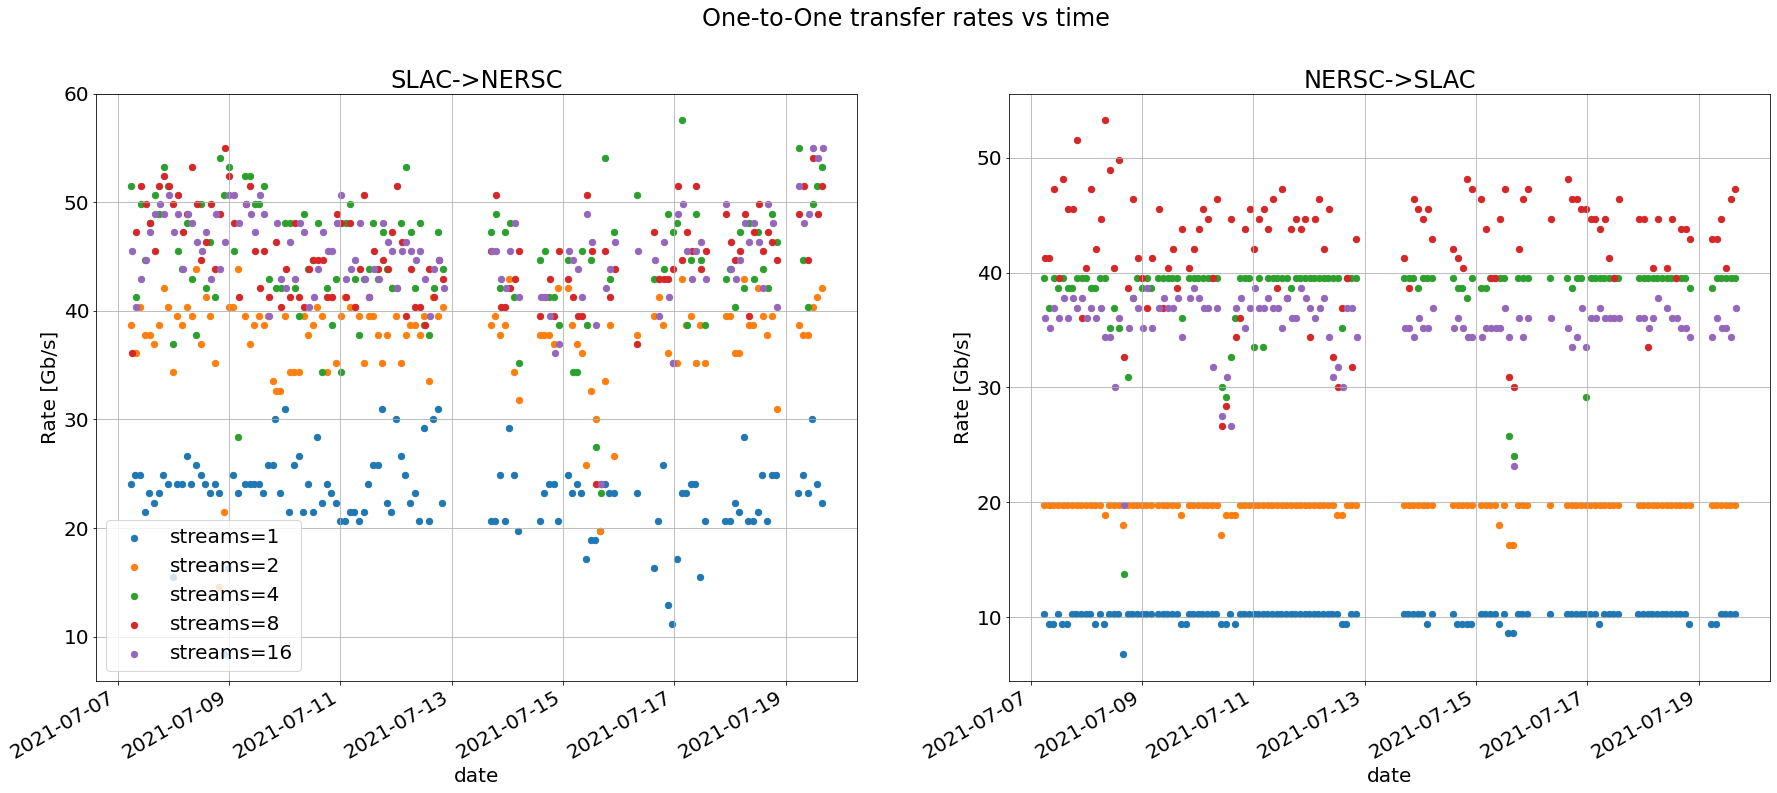

In [10]:
df = df_one

fig, axis = plt.subplots(1,2)
fig.set_size_inches(30,12)
fig.suptitle("One-to-One transfer rates vs time")

ax = axis[0]
df[ (df.streams == 1) & (df.reverse == 0) ].plot.scatter(x="date", y="rate", color="tab:blue", label="streams=1", s=40, ax=ax)
df[ (df.streams == 2) & (df.reverse == 0) ].plot.scatter(x="date", y="rate", color="tab:orange", label="streams=2", s=40, ax=ax)
df[ (df.streams == 4) & (df.reverse == 0) ].plot.scatter(x="date", y="rate", color="tab:green", label="streams=4", s=40, ax=ax)
df[ (df.streams == 8) & (df.reverse == 0) ].plot.scatter(x="date", y="rate", color="tab:red", label="streams=8", s=40, ax=ax)
df[ (df.streams == 16) & (df.reverse == 0) ].plot.scatter(x="date", y="rate", color="tab:purple", label="streams=16", s=40, ax=ax)

ax.grid()
ax.set_xlabel("date")
ax.set_ylabel("Rate [Gb/s]")
ax.set_title(f"SLAC->NERSC")
fig.autofmt_xdate()

ax = axis[1]
df[ (df.streams == 1) & (df.reverse == 1) ].plot.scatter(x="date", y="rate", color="tab:blue", s=40, ax=ax)
df[ (df.streams == 2) & (df.reverse == 1) ].plot.scatter(x="date", y="rate", color="tab:orange", s=40,ax=ax)
df[ (df.streams == 4) & (df.reverse == 1) ].plot.scatter(x="date", y="rate", color="tab:green", s=40, ax=ax)
df[ (df.streams == 8) & (df.reverse == 1) ].plot.scatter(x="date", y="rate", color="tab:red", s=40, ax=ax)
df[ (df.streams == 16) & (df.reverse == 1) ].plot.scatter(x="date", y="rate", color="tab:purple", s=40, ax=ax)

ax.grid()
ax.set_xlabel("date")
ax.set_ylabel("Rate [Gb/s]")
ax.fmt_xdata = mdates.DateFormatter('%m')
ax.set_title(f"NERSC->SLAC")
fig.autofmt_xdate()

Text(0.5, 1.0, 'NERSC->SLAC')

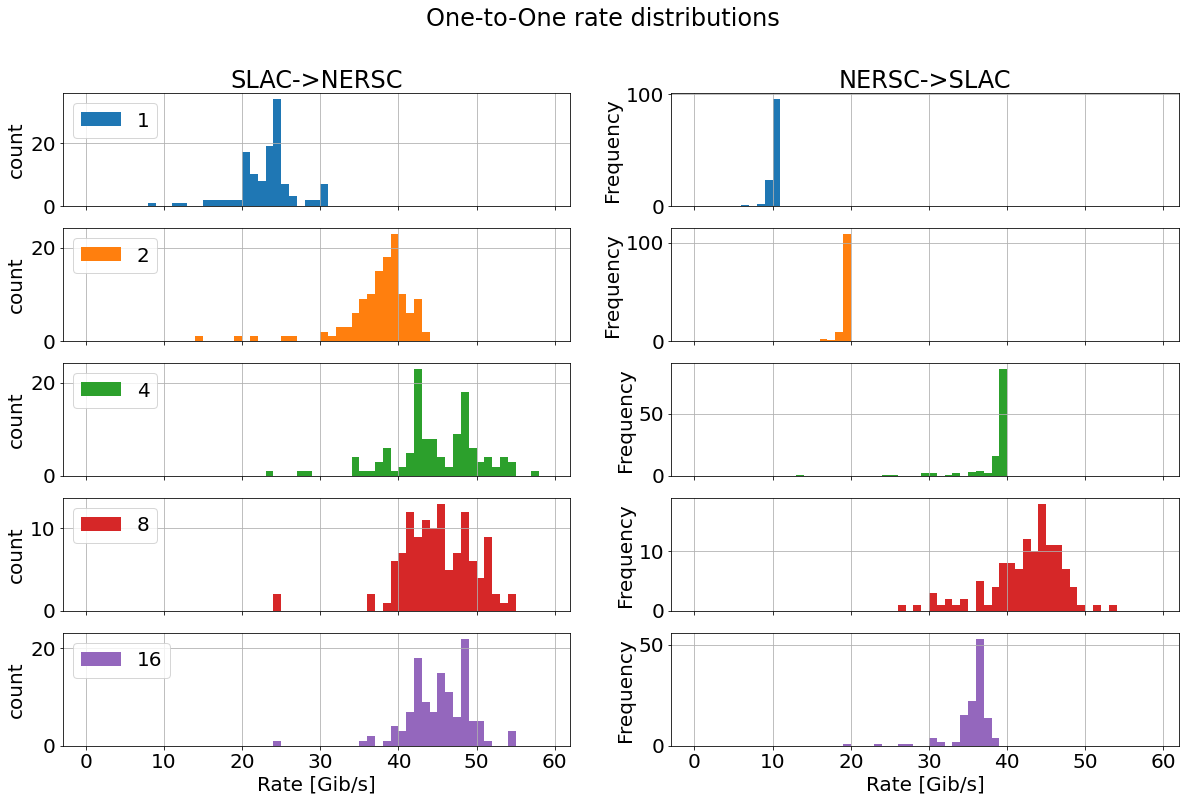

In [13]:
# Plot the rate distribution for different streams

df = df_one
fig, axis = plt.subplots(5,2, sharex=True)
ax = axis[0][0]
fig.set_size_inches(20,12)
fig.suptitle("One-to-One rate distributions")

colors = ("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple") 
for n, streams in enumerate((1, 2, 4, 8, 16)):
    ax = axis[n][0]
    df[ (df.reverse == 0) & (df.streams == streams) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n], label=streams, legend=True)
    ax.set_ylabel("count")
    ax.legend(loc=2)
    
    ax = axis[n][1]
    df[ (df.reverse == 1) & (df.streams == streams) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n])
    
axis[-1][0].set_xlabel("Rate [Gib/s]")
axis[0][0].set_title("SLAC->NERSC")

axis[-1][1].set_xlabel("Rate [Gib/s]")
axis[0][1].set_title("NERSC->SLAC")
    
#ax.set_xlabel("Rate [Gib/s]")
#ax.set_ylabel("count")
#ax.set_title(f"transfer rates SLAC -> NERSC")

#ax1 = axis[0][1]
#df[ df.reverse == 1 ].groupby("streams").rate.plot.hist(bins=list(range(0,60,1)), ax=ax1, grid=True, histtype="step")
#ax1.set_xlabel("Rate [GiBbs]")
#ax1.set_ylabel("count")
#ax1.set_title(f"transfer rates NERSC -> SLAC")

# Many-pairs transfers

Text(0, 0.5, 'count')

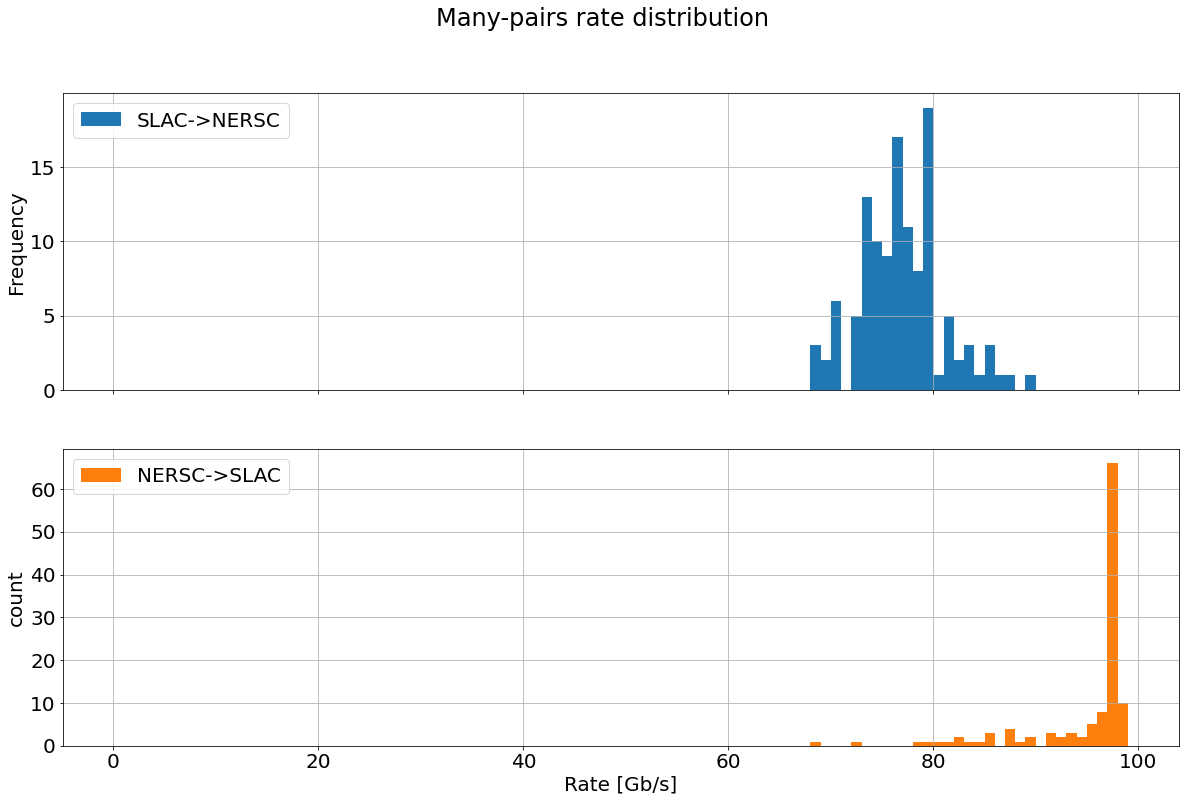

In [6]:

df = df_mny
fig, axis = plt.subplots(2,1, sharex=True)
fig.set_size_inches(20,12)
fig.suptitle("Many-pairs rate distribution")

ax = axis[0]
df[ (df.reverse == 0) ].rate.plot.hist(bins=range(0,100,1), ax=axis[0], grid=True, color="tab:blue", label="SLAC->NERSC", legend=True)
df[ (df.reverse == 1) ].rate.plot.hist(bins=range(0,100,1), ax=axis[1], grid=True, color="tab:orange", label="NERSC->SLAC", legend=True)
axis[0].legend(loc=2)
axis[1].legend(loc=2)

#df_mny.groupby("reverse").rate.plot.hist(legend=True, grid=True, histtype="step")
axis[1].set_xlabel("Rate [Gb/s]")
axis[1].set_ylabel("count")

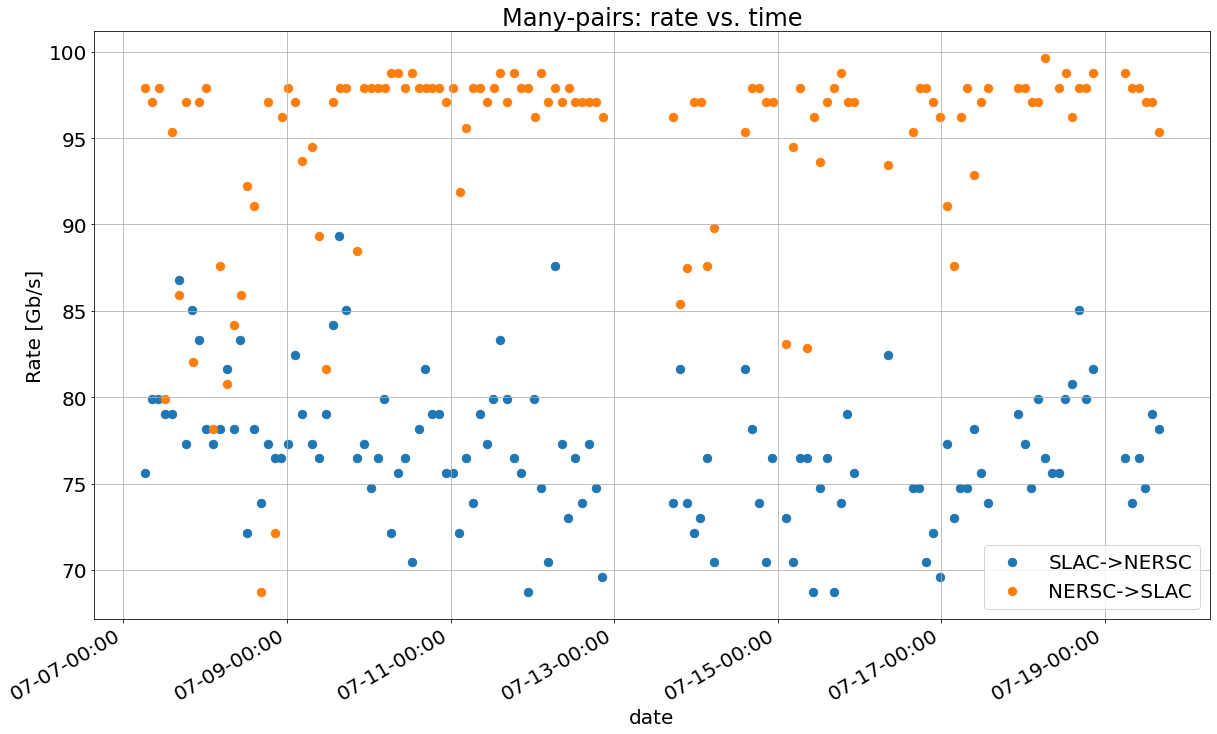

In [7]:
df = df_mny
fig, ax = plt.subplots(1)
fig.set_size_inches(20,12)
ax.fmt_xdata = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%H:%M'))

df[ df.reverse == 0 ].plot.scatter(x="date", y="rate", color="tab:blue", label="SLAC->NERSC", s=70, ax=ax)
df[ df.reverse == 1 ].plot.scatter(x="date", y="rate", color="tab:orange", label="NERSC->SLAC", s=70, ax=ax)

ax.grid()
ax.set_xlabel("date")
ax.set_ylabel("Rate [Gb/s]")
ax.set_title(f"Many-pairs: rate vs. time")
fig.autofmt_xdate()

In [8]:
# Mean and standard variantion 

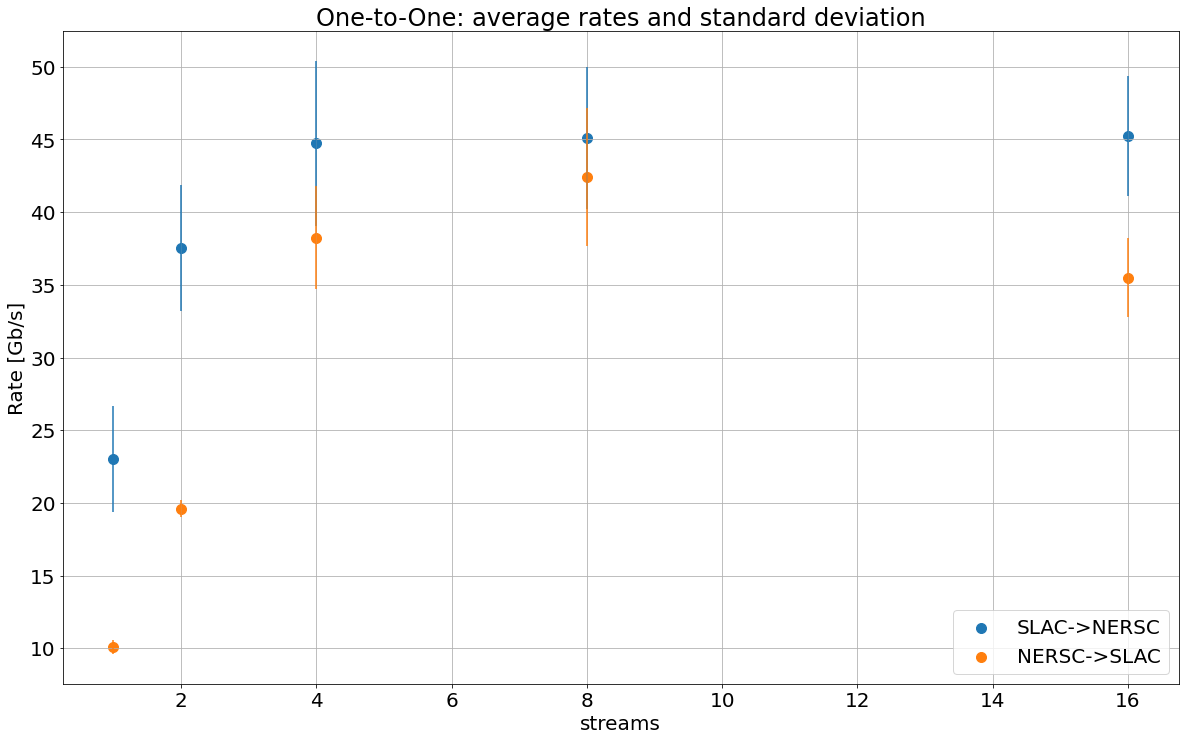

In [9]:
# Plot mean and variation for One-to-One transfers  vs. #streams
stats_1_1 = df_one.groupby(["streams","reverse"]).rate.agg(['mean','std'])
stats_1_1.iloc[ stats_1_1.index.get_level_values('reverse') == 0 ]

fig, ax = plt.subplots(1)
fig.set_size_inches(20,12)

stats_1_1[ stats_1_1.index.get_level_values('reverse') == 0 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:blue", ax=ax, s=100, yerr='std', label="SLAC->NERSC")
stats_1_1[ stats_1_1.index.get_level_values('reverse') == 1 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:orange", ax=ax, s=100, yerr='std', label="NERSC->SLAC")

ax.grid()
ax.set_title(f"One-to-One: average rates and standard deviation")
ax.set_xlabel("streams")
ax.set_ylabel("Rate [Gb/s]")
ax.legend(loc=4)

Text(0, 0.5, 'Rate [Gb/s]')

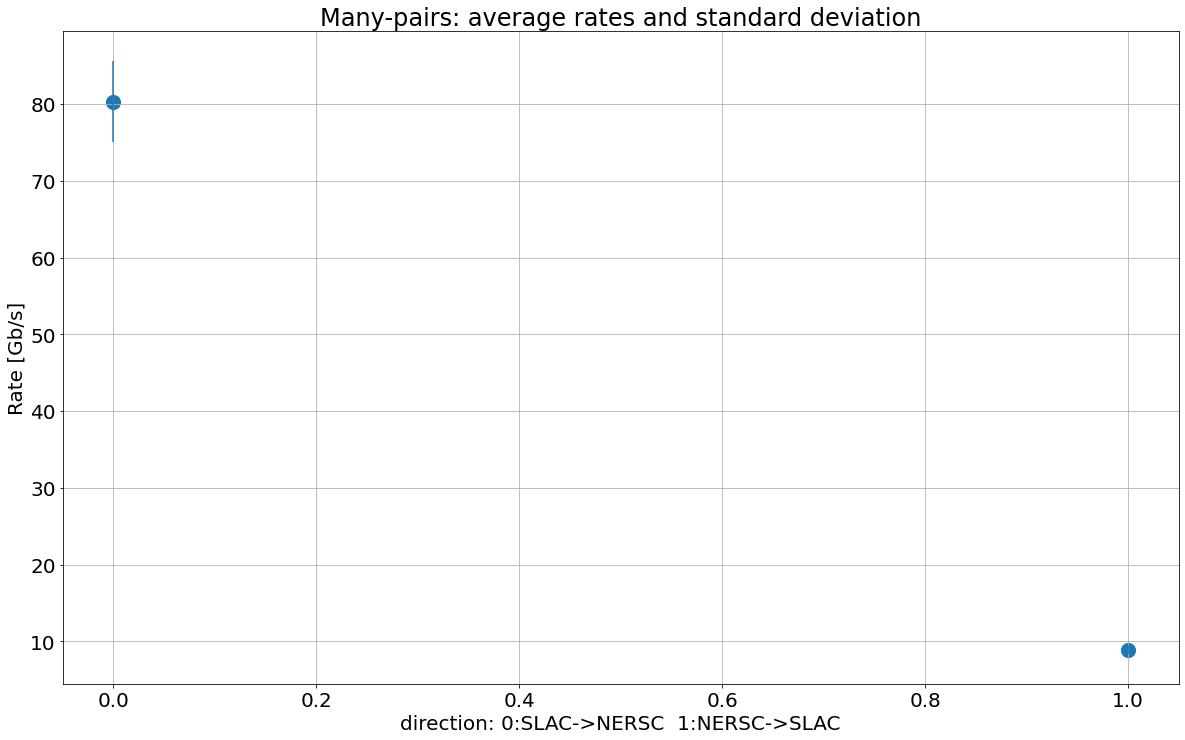

In [19]:
stats_m_m = df_mny.groupby("reverse").rate.agg(['mean','std'])
fig, ax = plt.subplots(1)
fig.set_size_inches(20,12)

stats_m_m.reset_index().plot.scatter(x='reverse', y='mean', ax=ax, s=200, yerr="std")
ax.grid()
ax.set_title(f"Many-pairs: average rates and standard deviation")
ax.set_xlabel("direction: 0:SLAC->NERSC  1:NERSC->SLAC")
ax.set_ylabel("Rate [Gb/s]")